In [1]:
import cell2cell as c2c
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mlp
from mpl_toolkits.mplot3d import Axes3D

import skbio, scipy

%matplotlib inline

# Analysis Setup

Here, all inputs and parameters needed for the analysis are defined

**Location of files**

**<font color=red>When using other organism, it is important to have the same gene IDs or names in all the data sources. *That is, rnaseq, ppi and go_annotations*.</font>**

In [2]:
files = dict()
files['rnaseq_1'] = '/home/hsher/c2c_input/wolock_mapped_matrix.xlsx'
files['metadata_1'] = '/home/hsher/c2c_input/wolock_metadata_1122.xlsx'
files['rnaseq_2'] = '/home/hsher/c2c_input/pellin_lin_matrix.xlsx'
files['metadata_2'] = '/home/hsher/c2c_input/pellin_lin_metadata_1211.xlsx'
files['ppi'] = '/home/hsher/ppi/receptor-ligand-bader.tsv'
files['output_folder'] = '/home/hsher/c2c_output/'

**RNA-seq data manipulation**

- <font color="green">'gene_col'</font> is the name of the column containing the list or names of genes in the dataset.
- <font color="green">'drop_nangenes'</font> is a boolean decision to remove those genes with NaN values.
- <font color="green">'log_transform'</font> is a boolean decision to log-transform the dataset.

In [3]:
rnaseq_setup = dict()
rnaseq_setup['gene_col'] = None
rnaseq_setup['drop_nangenes'] = True
rnaseq_setup['log_transform'] = False

**Metadata columns**

- <font color="green">'sample_col'</font> is the name of the column containing the sample or cell names in RNA-seq data (equivalent to the columns in rnaseq_data.
- <font color="green">'group_col'</font> is the name of the column containing the labels for the respective samples or cells in order to group/color them in downstream analyses.

In [4]:
meta_setup = dict()
meta_setup['sample_col'] = 'Cell cluster'
meta_setup['group_col'] = 'FACs annotation'

**Columns for PPI network**

- <font color="green">'protein_cols'</font> is a list containing the names of the first and second interactors.

In [5]:
ppi_setup = dict()
ppi_setup['protein_cols'] = ['AliasA', 'AliasB']

**Cutoffs setup for binarizing gene expression**

- <font color="green">'type'</font> is the type of cutoff to use. So far, only 'local_percentile' and 'global_percentile' are implemented. Local percentile is used to compute the cutoff locally, gene by gene; while a global percentiles is calculated from the entire dataset.
- <font color="green">'parameter'</font> is the corresponding parameter for the type of cutoff. If percentile is used, it should be a value between 0 and 1. E.g. a value of 0.75 represents the 75-th percentile, and the cutoff to binarize the gene expression will be that value.

In [6]:
cutoff_setup = dict()
cutoff_setup['type'] = 'local_percentile'
cutoff_setup['parameter'] = 0.75

**General Analysis setups**

- <font color="green">'score_type'</font> is the type of score to calculate the interaction index for a pair of cells. It could be 'binary' to use 0 or 1 values of gene expression depending on a cutoff value for each one or 'weighted' to use a continue value between 0 and 1 given the maximal expression level of each gene.
- <font color="green">'score_metric'</font> is the metric approach to compute the score. Current options are 'bray_curtis' and 'jaccard'.

In [7]:
analysis_setup = dict()
analysis_setup['score_type'] = 'binary'
analysis_setup['score_metric'] = 'bray_curtis'

# Load Data

**RNA-seq**

In [8]:
stroma_rnaseq = c2c.io.load_rnaseq(rnaseq_file=files['rnaseq_1'],
                                  gene_column=rnaseq_setup['gene_col'],
                                  drop_nangenes=rnaseq_setup['drop_nangenes'],
                                  log_transformation=rnaseq_setup['log_transform'],
                                  format='auto')

Opening RNAseq datasets from /home/hsher/c2c_input/wolock_mapped_matrix.xlsx
/home/hsher/c2c_input/wolock_mapped_matrix.xlsx was correctly loaded


In [9]:
hema_rnaseq = c2c.io.load_rnaseq(rnaseq_file=files['rnaseq_2'],
                                  gene_column=rnaseq_setup['gene_col'],
                                  drop_nangenes=rnaseq_setup['drop_nangenes'],
                                  log_transformation=rnaseq_setup['log_transform'],
                                  format='auto')

Opening RNAseq datasets from /home/hsher/c2c_input/pellin_lin_matrix.xlsx
/home/hsher/c2c_input/pellin_lin_matrix.xlsx was correctly loaded


In [10]:
hema_rnaseq.shape
hema_rnaseq.index.name = 'gene_id'

In [11]:
stroma_rnaseq.shape
stroma_rnaseq.index.name = 'gene_id'

**Metadata for cell types**

In [12]:
def preprocess_metadata(metadata_key):
    meta = c2c.io.load_table(files[metadata_key], format='auto')
    meta.columns = ['old cluster', 'FACs annotation']
    meta['old cluster'] = meta['old cluster'].astype(str)
    
    return(meta)
stroma_meta = preprocess_metadata('metadata_1')
hema_meta = preprocess_metadata('metadata_2')

/home/hsher/c2c_input/wolock_metadata_1122.xlsx was correctly loaded
/home/hsher/c2c_input/pellin_lin_metadata_1211.xlsx was correctly loaded


In [13]:
# add a column to describe 
hema_meta['dataset'] = 'hema'
stroma_meta['dataset'] = 'stroma'

In [14]:
merged_meta = stroma_meta.append(hema_meta)

In [15]:
merged_meta['Cell cluster'] = np.arange(0,merged_meta.shape[0])

In [16]:
merged_meta['Cell cluster'] = merged_meta['Cell cluster'].astype(str)

**PPI network**

In [17]:
# generate rnaseq_data.index
complete_gene_list = list(set(stroma_rnaseq.index).union(set(hema_rnaseq.index)))
ppi_data = c2c.io.load_ppi(ppi_file=files['ppi'],
                           interaction_columns=ppi_setup['protein_cols'],
                           rnaseq_genes=complete_gene_list,
                           format='auto')

Opening PPI datasets from /home/hsher/ppi/receptor-ligand-bader.tsv


/home/hsher/miniconda3/envs/cell2cell/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (4,5,6,7,8,9,11,12,16) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


/home/hsher/ppi/receptor-ligand-bader.tsv was correctly loaded
Removing bidirectionality of PPI network
Simplying PPI network


In [18]:
ppi_data = ppi_data.drop_duplicates().reset_index(drop=True)

# subsetting RNA-seq, remove duplicate and merge

In [19]:
#subset_of_interest = [0,1,3,4,6,9,10,13]
#subset_of_interest = [str(s) for s in subset_of_interest]
all_proteins = set(ppi_data['A']).union(set(ppi_data['B']))
#rnaseq_data = rnaseq_data.loc[rnaseq_data.index.isin(all_proteins), subset_of_interest]

#meta = meta.loc[meta['Cell cluster'].isin(subset_of_interest)]

In [20]:
all_proteins = set(ppi_data['A']).union(set(ppi_data['B']))
def rnaseq_preprocessing(rnaseq_data):
    # select only proteins present in ppi data
    rnaseq_data = rnaseq_data.loc[rnaseq_data.index.isin(all_proteins)]
    # remove duplicated index
    rnaseq_data.reset_index(inplace = True)
    rnaseq_data.drop_duplicates(subset = ['gene_id'],inplace = True)
    rnaseq_data.set_index('gene_id', inplace = True)
    #rnaseq_data.drop('index', axis = 1, inplace = True)
    
    return(rnaseq_data)
    

In [21]:
stroma_rnaseq_processed = rnaseq_preprocessing(stroma_rnaseq)
hema_rnaseq_processed = rnaseq_preprocessing(hema_rnaseq)

/home/hsher/miniconda3/envs/cell2cell/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [22]:
stroma_rnaseq_processed.columns = stroma_rnaseq_processed.columns.map(merged_meta.loc[merged_meta['dataset'] == 'stroma'].set_index("old cluster")['Cell cluster'])

In [23]:
# change column to non-repeating integer based on numbers assigned in merged_metadata
stroma_rnaseq_processed.columns

Index(['7', '0', '3', '13', '10', '2', '9', '1', '15', '5', '6', '8', '4',
       '20', '12', '11', '22', '19', '16', '18', '17', '21', '14'],
      dtype='object')

In [24]:
hema_rnaseq_processed.columns = hema_rnaseq_processed.columns.map(merged_meta.loc[merged_meta['dataset'] == 'hema'].set_index("old cluster")['Cell cluster'])

In [25]:
hema_rnaseq_processed.columns

Index(['25', '26', '27', '37', '23', '36', '42', '41', '43', '34', '40', '29',
       '30', '32', '35', '38', '24', '31', '39', '28', '33'],
      dtype='object')

In [26]:
merged_rnaseq = hema_rnaseq_processed.merge(stroma_rnaseq_processed, how = 'outer', left_index = True, right_index = True).fillna(0)

# merge metadata

# Run Analysis

**Make PPI network bidirectional for bidirectional CCI**

In [27]:
print('PPI data has {} PPIs'.format(len(ppi_data)))

PPI data has 29264 PPIs


In [28]:
bi_ppi_data = c2c.preprocessing.bidirectional_ppi_for_cci(ppi_data=ppi_data)

Making bidirectional PPI for CCI.
Removing duplicates in bidirectional PPI network.


In [29]:
print('Bidirectional PPI data has {} PPIs'.format(len(bi_ppi_data)))

Bidirectional PPI data has 57796 PPIs


**Create InteractionSpace**

In [30]:
interaction_space = c2c.core.InteractionSpace(rnaseq_data=merged_rnaseq,
                                              ppi_data=bi_ppi_data,
                                              gene_cutoffs=cutoff_setup,
                                              score_type=analysis_setup['score_type'],
                                              score_metric=analysis_setup['score_metric'],
                                              verbose=False)

**Compute CCI values for each random subsampling round**

In [31]:
print('Running analysis')
interaction_space.compute_pairwise_interactions(verbose=False)

Running analysis


**Cells to exclude**

In [32]:
excluded_cells = []

# Clustering

### Hierarchical Clustering on Average CCI matrices

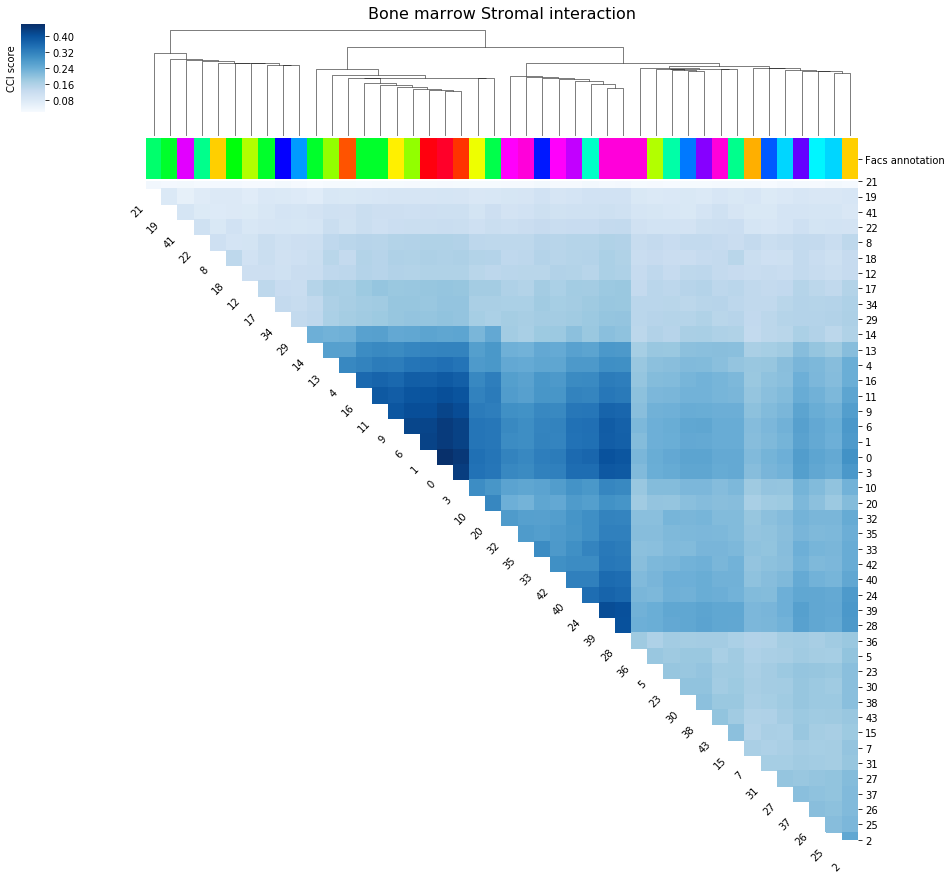

In [34]:
g = c2c.utils.clustermap_cci(interaction_space,
                         method='ward',
                         excluded_cells=excluded_cells,
                         metadata=merged_meta,
                         sample_col=meta_setup['sample_col'],
                         group_col=meta_setup['group_col'],
                         title='Bone marrow Stromal interaction',
                         #filename=files['output_folder'] + 'CCI-Imm-Bin-Clustering-{}.png'.format(selected_patient),
                         **{'cmap' : 'Blues',
                            #'annot' : True,
                            'figsize' : (15,15)
                           }
                         )

In [42]:
node_attr = merged_meta.set_index("Cell cluster")['FACs annotation'].to_dict()

In [43]:
import networkx as nx
net = nx.convert_matrix.from_pandas_adjacency(interaction_space.distance_matrix)
nx.set_node_attributes(net, node_attr, 'FACs')


/home/hsher/miniconda3/envs/cell2cell/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


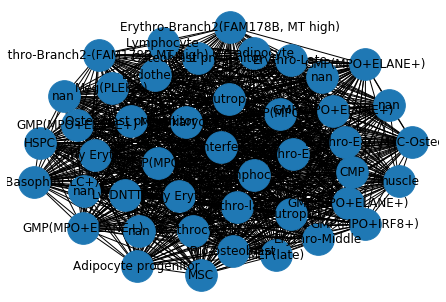

In [41]:
nx.draw(net,labels=node_attr,node_size=1000)


/home/hsher/miniconda3/envs/cell2cell/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


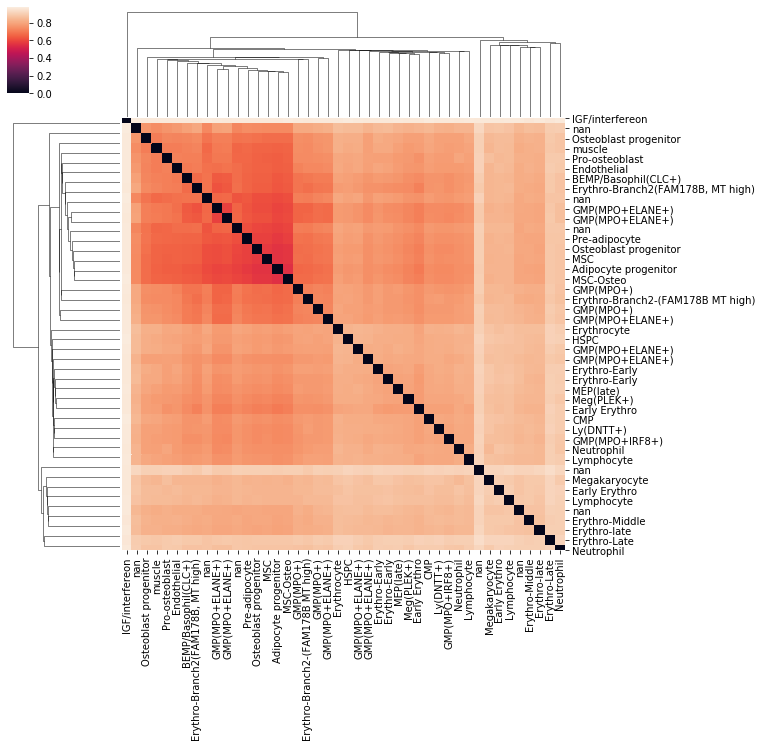

In [44]:
# try better visualization
import copy
import seaborn as sns
matrix_named = copy.copy(interaction_space.distance_matrix)
matrix_named.index = matrix_named.index.map(node_attr)
matrix_named.columns = matrix_named.index
sns.clustermap(matrix_named, yticklabels=True, xticklabels=True, linecolor="grey")

# Interaction Matrix

In [45]:
interaction_matrix, std_interaction_matrix = c2c.analysis.get_ppi_score_for_cell_pairs(cells=list(interaction_space.distance_matrix.columns),
                                                                                       subsampled_interactions=[interaction_space.interaction_elements],
                                                                                       ppi_data=bi_ppi_data,
                                                                                       ref_ppi_data=ppi_data
                                                                                       )

In [46]:
interaction_matrix.to_pickle('/home/hsher/c2c_output/hema_stroma_75')

Does the pooled RNA-seq make sense

In [47]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(merged_rnaseq.transpose().values)
X_embedded.shape

(44, 2)

In [48]:
len(merged_rnaseq.columns)

44

Text(0, 0.5, 'tSNE-2')

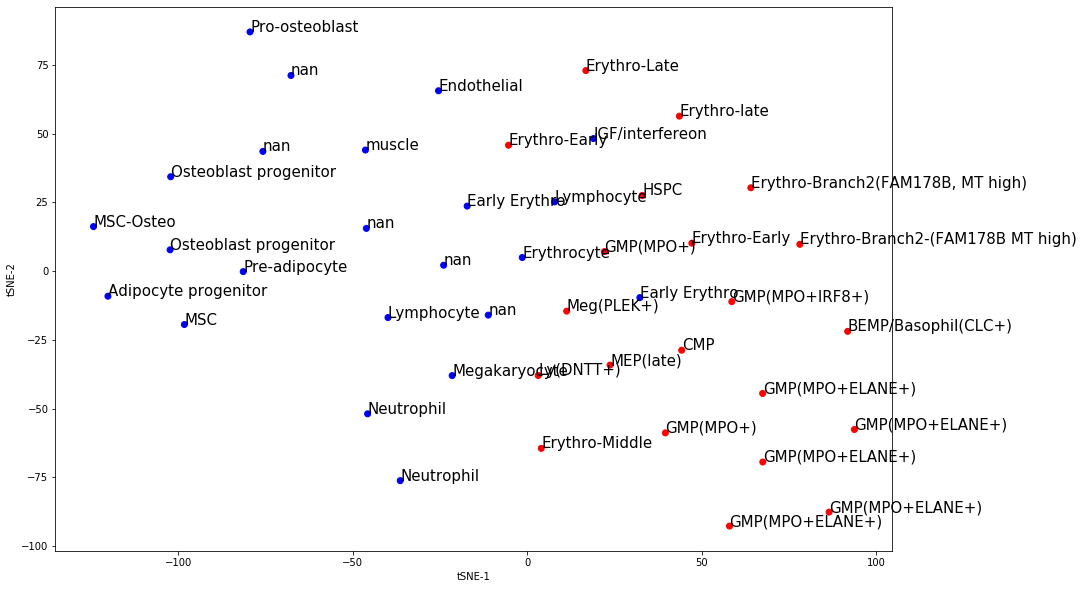

In [50]:
fig, ax = plt.subplots(figsize = (15,10))
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=['r']*21 + ['b']*23)
for i, txt in enumerate(list(merged_rnaseq.columns.map(node_attr))):
    ax.annotate(txt, (X_embedded[i, 0], X_embedded[i, 1]), size = 15)
ax.set_xlabel('tSNE-1')
ax.set_ylabel('tSNE-2')

In [52]:
merged_rnaseq.to_excel('/home/hsher/c2c_output/hema_stroma_rnaseq.xlsx')
merged_meta.to_excel('/home/hsher/c2c_output/hema_stroma_metadata.xlsx')

Text(0, 0.5, 'PCA-2')

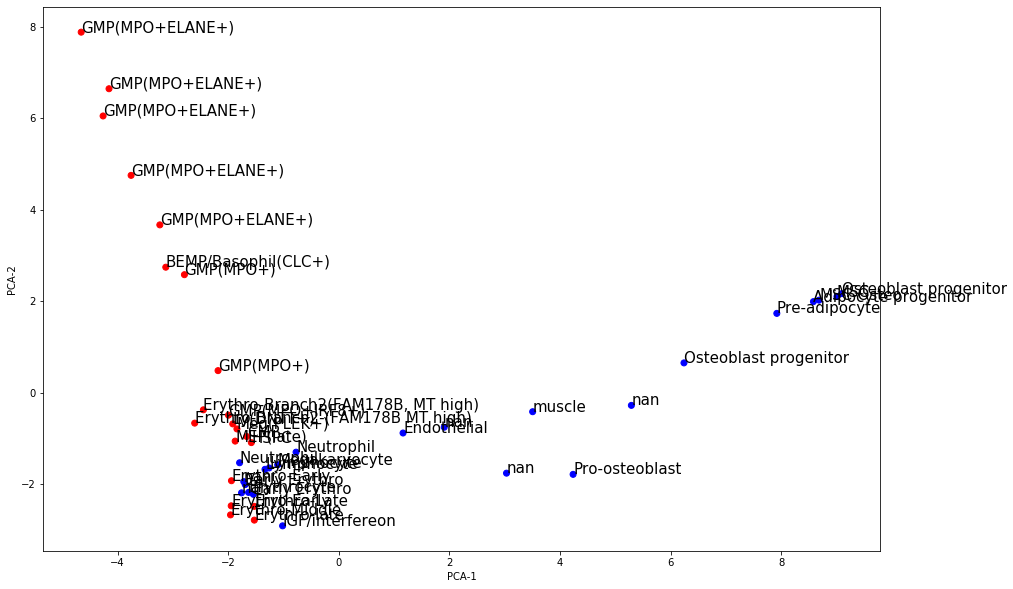

In [54]:
from sklearn.decomposition import PCA
X_embedded = PCA(n_components=2).fit_transform(merged_rnaseq.transpose().values)
X_embedded.shape
fig, ax = plt.subplots(figsize = (15,10))
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=['r']*21 + ['b']*23)
for i, txt in enumerate(list(merged_rnaseq.columns.map(node_attr))):
    ax.annotate(txt, (X_embedded[i, 0], X_embedded[i, 1]), size = 15)
ax.set_xlabel('PCA-1')
ax.set_ylabel('PCA-2')